# Full-Learning MNIST PC Network
Purpose: To see if we can learn not only (v)<->(e) connections, but also the (e)<->(v) connections. Those connections have previously been set to 1:1 identity mappings. But here they start as random connection weights, and learn using the same update rule as the other learning connections.

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import  datasets, transforms
from IPython.display import display
from ipywidgets import FloatProgress

%load_ext autoreload
%autoreload 1
%aimport PCNetwork
%aimport PCLayer
%aimport PCConnection

np.set_printoptions(precision=4)

dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device("cuda:5") # Uncomment this to run on GPU
else:
    device = torch.device("cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Dataset

In [59]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1, shuffle=True)

In [115]:
ds = datasets.MNIST('../data', train=True, transform=transforms.Compose([transforms.ToTensor()]))

In [119]:
ds[2][1]

4

TypeError: Invalid shape (1, 28, 28) for image data

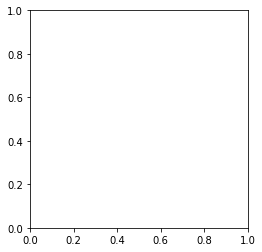

In [117]:
plt.imshow(ds[2][0])

In [143]:
class SmallMNIST(Dataset):
    def __init__(self, ds_full, n=100):
        self.samples = []
        self.n_classes = 10
        self.input_dim = 784
        for i in range(n):
            classvec = torch.zeros(10, dtype=torch.float32, device=device)
            classvec[ds_full[i][1]] = 1.
            sample = (ds_full[i][0].flatten().clone().detach().float().to(device), classvec)
            #sample = [A[r]+noise*torch.randn_like(A[r]), B[r]+noise*torch.randn_like(B[r])]
            self.samples.append(sample)
    
    def __getitem__(self, idx):
        return self.samples[idx]
        
    def __len__(self):
        return len(self.samples)

    def Inputs(self):
        x = []
        for s in self.samples:
            x.append(s[0])
        return torch.stack(x)
    
    def Targets(self):
        t = []
        for s in self.samples:
            t.append(s[1])
        return torch.stack(t)
            
    def InputsOfClass(self, c):
        x = []
        for s in self.samples:
            if torch.argmax(s[1])==c:
                x.append(s[0])
        return torch.stack(x)

    def Show(self, idx):
        plt.imshow(np.reshape(self.samples[idx][0].cpu(), (28,28)));

In [145]:
myds = SmallMNIST(ds)

In [146]:
myds[5][1]

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

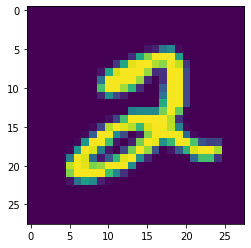

In [147]:
myds.Show(5)

# Create Network

In [150]:
#ds = SimpleDataset(A, B, n=50, noise=0.2)
dl = DataLoader(myds, batch_size=10, shuffle=True)

In [151]:
input_dim = 784
mid_dim = 100
net = PCNetwork.PCNetwork()
net.AddLayer(PCLayer.PCLayer(n=myds.input_dim))  # [0] v0 input

net.AddLayer(PCLayer.PCLayer(n=mid_dim))       # [1] e1 error
net.AddLayer(PCLayer.PCLayer(n=mid_dim))       # [2] v1 class

net.AddLayer(PCLayer.PCLayer(n=myds.n_classes))  # [3] e2 error
net.AddLayer(PCLayer.PCLayer(n=myds.n_classes))  # [4] v2 class

af0 = 'identity'
af = 'tanh'
sym = False
net.Connect(v_idx=0, e_idx=1, type='general', sym=sym, act_text=af0)
net.Connect(v_idx=2, e_idx=1, type='general', sym=False, act_text=af)
net.Connect(v_idx=2, e_idx=3, type='general', sym=sym, act_text=af)
net.Connect(v_idx=4, e_idx=3, type='general', sym=False, act_text=af)

net.SetTau(0.05)

# Training

In [152]:
net.ClearHistory()
net.Probe(True)
net.Learning(True)
net.SetGamma(0.1)
mult = 1.
l = 0.
h = 1.


# Connection (v0)--(e1)
net.con[0].SetRandomUniform(low=l, high=h) # e1-v1
net.con[1].SetRandomUniform(low=l, high=h) # e1-v1
#net.con[1].SetIdentity()
net.con[2].SetRandomUniform(low=l, high=h) # v1-e2
net.con[3].SetRandomUniform(low=l, high=h) # e2-v2
#net.con[3].SetIdentity()

net.SetDynamicWeightDecay(0.0, 0.8)
net.SetRepelSmallWeights(0.0)
net.SetActivityDecay(0.0)
net.SetBlackout(0.)

In [49]:
net.ClearHistory()

In [153]:
net.Learning(True)
net.con[0].Learning(False)
net.con[1].Learning(True)
net.con[2].Learning(False)
net.con[3].Learning(True)
net.SetDynamicWeightDecay(0.0, 0.8)
net.Learn(dl, T=1., epochs=2)

Epoch: 0 weight decay = 0.0
Epoch: 1 weight decay = 0.0


In [762]:
net.Learning(True)
net.con[0].Learning(True)
net.con[1].Learning(False)
net.con[2].Learning(True)
net.con[3].Learning(False)
net.SetDynamicWeightDecay(0.01, 0.8)
net.Learn(dl, T=3., epochs=2)

Epoch: 0 weight decay = 0.01
Epoch: 1 weight decay = 0.002


In [763]:
net.Learning(True)
net.con[0].Learning(False)
net.con[1].Learning(True)
net.con[2].Learning(False)
net.con[3].Learning(True)
net.SetDynamicWeightDecay(0.0, 0.8)
net.Learn(dl, T=3., epochs=2)

Epoch: 0 weight decay = 0.0
Epoch: 1 weight decay = 0.0


In [764]:
net.Learning(True)
net.con[0].Learning(True)
net.con[1].Learning(False)
net.con[2].Learning(True)
net.con[3].Learning(False)
net.SetDynamicWeightDecay(0.0, 0.8)
net.Learn(dl, T=3., epochs=2)

Epoch: 0 weight decay = 0.0
Epoch: 1 weight decay = 0.0


In [766]:
print(net.con[0].M)
print(net.con[0].W.transpose(1,0))
print(net.con[1].M)
print(net.con[1].W.transpose(1,0))
print(net.con[2].M)
print(net.con[2].W.transpose(1,0))
print(net.con[3].M)
print(net.con[3].W.transpose(1,0))

tensor([[-0.0264,  0.2112,  0.1106,  0.2394,  0.1933,  0.2092,  0.2339,  0.0871],
        [ 0.0821,  0.2337,  0.0253,  0.1303,  0.0917,  0.1501,  0.1762,  0.1607],
        [ 0.1601,  0.1574,  0.1022,  0.3242,  0.3063,  0.3169,  0.1897,  0.0769],
        [-0.0481,  0.2422,  0.1442,  0.0473,  0.0473,  0.0115,  0.0544,  0.1189],
        [ 0.0938,  0.1337,  0.0580,  0.0822,  0.0675,  0.0691,  0.0799,  0.1175],
        [ 0.0809,  0.1652,  0.0759,  0.1380,  0.1283,  0.1075,  0.0554,  0.1454],
        [ 0.2911,  0.2913,  0.0682,  0.0936,  0.1170,  0.1111,  0.0980,  0.2279],
        [ 0.1513,  0.1956,  0.1218,  0.2576,  0.2469,  0.2444,  0.1671,  0.0953],
        [-0.1990,  0.1860,  0.0905,  0.0982,  0.0289,  0.0393,  0.1333,  0.1144],
        [ 0.2702,  0.2892,  0.0763,  0.2067,  0.1946,  0.2296,  0.2394,  0.2191]])
tensor([[-0.0027,  0.3860,  0.1231,  0.2611,  0.0087,  0.3211,  0.1901,  0.3265],
        [ 0.3434,  0.1635,  0.0953,  0.1925,  0.1717,  0.2118,  0.0493,  0.2749],
        [ 0.220

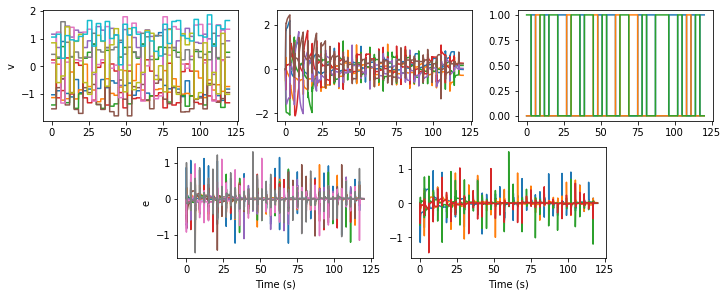

In [767]:
net.Plot(idx=0);

# Classification

In [27]:
net.Reset(random=1.)
net.Probe(True)
net.SetActivityDecay( 0.0 )
y = net.Predict(ds.Inputs(), T=.006)
print(y[:10])
print(ds.Targets()[:10])

tensor([[ 1.0425, -1.2034,  0.4170],
        [-0.7982, -0.0418, -0.2514],
        [-1.6355, -0.7326,  0.6587],
        [-0.0017, -0.1540, -0.9371],
        [ 0.8206,  0.9033, -0.6047],
        [ 0.6078, -0.0915, -0.0131],
        [-0.7135,  0.4089, -0.6572],
        [ 0.9165,  1.1141,  1.2641],
        [ 0.4625,  0.8008, -1.0573],
        [-0.1807,  0.2728,  0.2177]])
tensor([[1., 0., 0.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]])


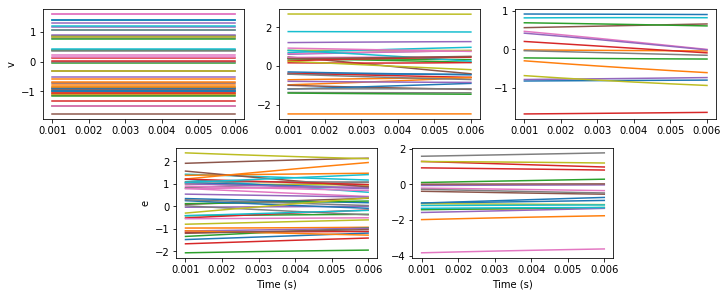

In [28]:
net.Plot(idx=[1,2,3,4,5]);

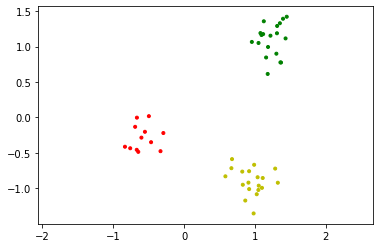

In [772]:
ds.Plot(labels=y, idx=(4,8))

# Generation

In [559]:
net.Reset(random=1.)
net.SetActivityDecay(0.02)
X = net.Generate(ds.Targets(), T=15.)

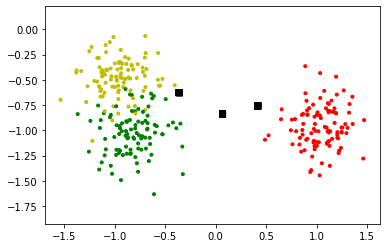

In [560]:
sidx = (0,1)
ds.Plot(idx=sidx)
plt.plot(X[:,sidx[0]], X[:,sidx[1]], 's', color=[0,0,0,0.1]);

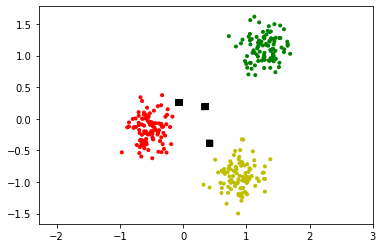

In [561]:
sidx = (4,8)
ds.Plot(idx=sidx)
plt.plot(X[:,sidx[0]], X[:,sidx[1]], 's', color=[0,0,0,0.1]);